# Soal 1: Imputasi Data Iklim BMKG

## Assignment CLO 2 & 3 - Sistem Cerdas IoT

**Tujuan:** Melakukan imputasi missing value pada data iklim menggunakan:
1. **Linear Interpolation**
2. **Prophet**

**Parameter yang diimputasi:**
- TAVG (Temperatur rata-rata °C)
- RH_AVG (Kelembapan rata-rata %)
- RR (Curah hujan mm)
- FF_AVG (Kecepatan angin rata-rata m/s)

**Dataset:** Data Iklim BMKG - Stasiun Geofisika Bandung 2024

## 1. Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

print("Library berhasil diimport!")

d:\TelkomUNiversity\IOT\Last CLO\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Library berhasil diimport!


## 2. Load dan Preprocessing Data

In [2]:
# Load data, skip 7 baris header
df = pd.read_csv('laporan_iklim.csv', skiprows=7)

# Ambil kolom yang diperlukan saja
df = df.iloc[:, :5]
df.columns = ['TANGGAL', 'TAVG', 'RH_AVG', 'RR', 'FF_AVG']

# Konversi tanggal
df['TANGGAL'] = pd.to_datetime(df['TANGGAL'], format='%d-%m-%Y')
df = df.set_index('TANGGAL')

# Konversi kolom numerik
params = ['TAVG', 'RH_AVG', 'RR', 'FF_AVG']
for col in params:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Ganti nilai 8888 dan 9999 dengan NaN (missing value)
df = df.replace([8888, 9999], np.nan)

print("=" * 60)
print("DATA IKLIM BMKG - STASIUN GEOFISIKA BANDUNG")
print("=" * 60)
print(f"Periode data: {df.index.min().strftime('%d-%m-%Y')} s.d. {df.index.max().strftime('%d-%m-%Y')}")
print(f"Jumlah data: {len(df)} hari")
print("\nPreview data:")
df.head(10)

DATA IKLIM BMKG - STASIUN GEOFISIKA BANDUNG
Periode data: 04-01-2024 s.d. 31-12-2024
Jumlah data: 363 hari

Preview data:


,TAVG,RH_AVG,RR,FF_AVG
TANGGAL,,,,
2024-01-04,22.5,91.0,1.6,0
2024-01-05,23.9,82.0,32.5,0
2024-01-06,23.4,87.0,22.5,0
2024-01-07,22.8,90.0,9.3,0
2024-01-08,23.8,85.0,37.2,0
2024-01-09,23.5,86.0,2.8,0
2024-01-10,23.6,88.0,14.3,0
2024-01-11,22.9,91.0,61.7,0
2024-01-12,24.5,76.0,49.3,0


## 3. Cek Missing Value

Sebelum melakukan imputasi, kita perlu mengecek berapa banyak missing value pada setiap parameter.

**Keterangan nilai khusus dari BMKG:**
- `8888` = Data tidak terukur
- `9999` = Tidak ada data (tidak dilakukan pengukuran)

MISSING VALUE SEBELUM IMPUTASI
        Jumlah Missing  Persentase (%)
TAVG                 1            0.28
RH_AVG               1            0.28
RR                  56           15.43
FF_AVG               0            0.00

📊 Visualisasi Missing Value:


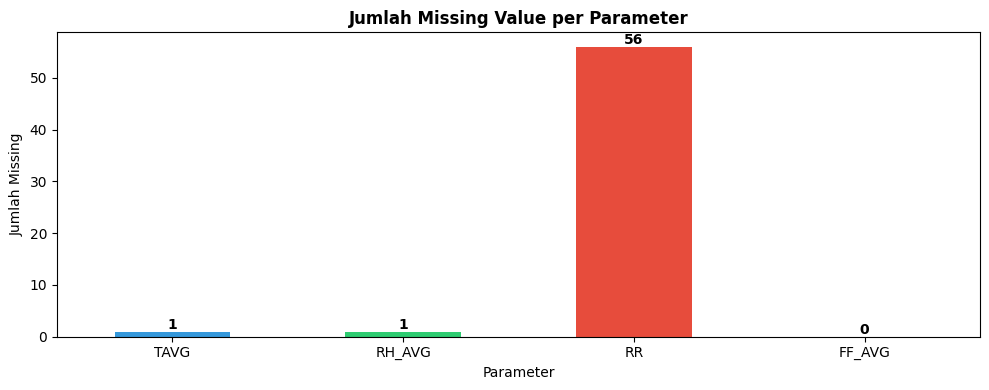

In [3]:
# Cek missing value
print("=" * 60)
print("MISSING VALUE SEBELUM IMPUTASI")
print("=" * 60)

missing_info = pd.DataFrame({
    'Jumlah Missing': df[params].isnull().sum(),
    'Persentase (%)': (df[params].isnull().sum() / len(df) * 100).round(2)
})
print(missing_info)

# Simpan posisi missing value untuk evaluasi nanti
missing_mask = df[params].isnull()

# Visualisasi missing value
print("\n📊 Visualisasi Missing Value:")
fig, ax = plt.subplots(figsize=(10, 4))
missing_info['Jumlah Missing'].plot(kind='bar', color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6'], ax=ax)
ax.set_title('Jumlah Missing Value per Parameter', fontsize=12, fontweight='bold')
ax.set_xlabel('Parameter')
ax.set_ylabel('Jumlah Missing')
ax.set_xticklabels(params, rotation=0)
for i, v in enumerate(missing_info['Jumlah Missing']):
    ax.text(i, v + 0.5, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Metode 1: Linear Interpolation

**Linear Interpolation** adalah metode imputasi yang mengisi missing value dengan nilai yang diinterpolasi secara linear antara dua titik data yang ada.

**Kelebihan:**
- Cepat dan sederhana
- Cocok untuk data yang perubahannya gradual

**Kekurangan:**
- Tidak memperhitungkan pola musiman (seasonality)

In [4]:
# Imputasi dengan Linear Interpolation
df_linear = df.copy()

for col in params:
    df_linear[col] = df_linear[col].interpolate(method='linear')
    # Isi nilai di awal/akhir jika masih ada NaN
    df_linear[col] = df_linear[col].fillna(method='ffill').fillna(method='bfill')

print("=" * 60)
print("HASIL IMPUTASI LINEAR INTERPOLATION")
print("=" * 60)
print(f"Missing value tersisa: {df_linear[params].isnull().sum().sum()}")

# Simpan hasil
df_linear.to_csv('DATA/2024_linear.csv')
print("\n✅ Data disimpan ke: DATA/2024_linear.csv")

df_linear.head(10)

HASIL IMPUTASI LINEAR INTERPOLATION
Missing value tersisa: 0

✅ Data disimpan ke: DATA/2024_linear.csv


,TAVG,RH_AVG,RR,FF_AVG
TANGGAL,,,,
2024-01-04,22.5,91.0,1.60,0
2024-01-05,23.9,82.0,32.50,0
2024-01-06,23.4,87.0,22.50,0
2024-01-07,22.8,90.0,9.30,0
2024-01-08,23.8,85.0,37.20,0
2024-01-09,23.5,86.0,2.80,0
2024-01-10,23.6,88.0,14.30,0
2024-01-11,22.9,91.0,61.70,0
2024-01-12,24.5,76.0,49.30,0


## 5. Metode 2: Prophet Imputation

**Prophet** adalah library forecasting dari Facebook yang dapat memprediksi nilai berdasarkan pola trend dan seasonality.

**Kelebihan:**
- Memperhitungkan trend dan seasonality (harian, mingguan, tahunan)
- Robust terhadap missing data dan outlier

**Kekurangan:**
- Lebih kompleks dan lambat
- Membutuhkan lebih banyak data untuk akurasi

In [5]:
def impute_with_prophet(series, col_name):
    """
    Melakukan imputasi menggunakan Prophet
    """
    # Siapkan data untuk Prophet
    df_temp = pd.DataFrame({
        'ds': series.index,
        'y': series.values
    })
    
    # Pisahkan data yang ada nilainya untuk training
    df_train = df_temp.dropna()
    
    if len(df_train) < 10:
        print(f"  ⚠️ Data {col_name} terlalu sedikit untuk Prophet, gunakan linear")
        return series.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
    
    # Buat dan fit model Prophet
    model = Prophet(
        daily_seasonality=True,
        yearly_seasonality=True,
        weekly_seasonality=True,
        changepoint_prior_scale=0.05
    )
    model.fit(df_train)
    
    # Prediksi untuk semua tanggal
    future = pd.DataFrame({'ds': series.index})
    forecast = model.predict(future)
    
    # Isi missing value dengan hasil prediksi Prophet
    result = series.copy()
    missing_idx = series[series.isnull()].index
    
    for idx in missing_idx:
        pred_value = forecast[forecast['ds'] == idx]['yhat'].values
        if len(pred_value) > 0:
            result[idx] = pred_value[0]
    
    return result

# Imputasi dengan Prophet
df_prophet = df.copy()

print("=" * 60)
print("PROSES IMPUTASI DENGAN PROPHET")
print("=" * 60)

for col in params:
    print(f"📊 Memproses {col}...")
    df_prophet[col] = impute_with_prophet(df_prophet[col], col)

# Pastikan tidak ada NaN tersisa
for col in params:
    df_prophet[col] = df_prophet[col].fillna(method='ffill').fillna(method='bfill')

print("\n" + "=" * 60)
print("HASIL IMPUTASI PROPHET")
print("=" * 60)
print(f"Missing value tersisa: {df_prophet[params].isnull().sum().sum()}")

# Simpan hasil
df_prophet.to_csv('DATA/2024_prophet.csv')
print("\n✅ Data disimpan ke: DATA/2024_prophet.csv")

df_prophet.head(10)

PROSES IMPUTASI DENGAN PROPHET
📊 Memproses TAVG...


14:20:57 - cmdstanpy - INFO - Chain [1] start processing
14:20:57 - cmdstanpy - INFO - Chain [1] done processing


📊 Memproses RH_AVG...


14:20:57 - cmdstanpy - INFO - Chain [1] start processing
14:20:57 - cmdstanpy - INFO - Chain [1] done processing


📊 Memproses RR...


14:20:58 - cmdstanpy - INFO - Chain [1] start processing
14:20:58 - cmdstanpy - INFO - Chain [1] done processing


📊 Memproses FF_AVG...


14:20:58 - cmdstanpy - INFO - Chain [1] start processing
14:20:58 - cmdstanpy - INFO - Chain [1] done processing



HASIL IMPUTASI PROPHET
Missing value tersisa: 0

✅ Data disimpan ke: DATA/2024_prophet.csv


,TAVG,RH_AVG,RR,FF_AVG
TANGGAL,,,,
2024-01-04,22.5,91.0,1.600000,0
2024-01-05,23.9,82.0,32.500000,0
2024-01-06,23.4,87.0,22.500000,0
2024-01-07,22.8,90.0,9.300000,0
2024-01-08,23.8,85.0,37.200000,0
2024-01-09,23.5,86.0,2.800000,0
2024-01-10,23.6,88.0,14.300000,0
2024-01-11,22.9,91.0,61.700000,0
2024-01-12,24.5,76.0,49.300000,0


## 6. Plot Hasil Imputasi Linear Interpolation

Visualisasi hasil imputasi untuk setiap parameter cuaca menggunakan metode **Linear Interpolation**.

Titik oranye menunjukkan posisi nilai yang diimputasi.

✅ Plot disimpan ke: DATA/plot_imputasi_linear.png


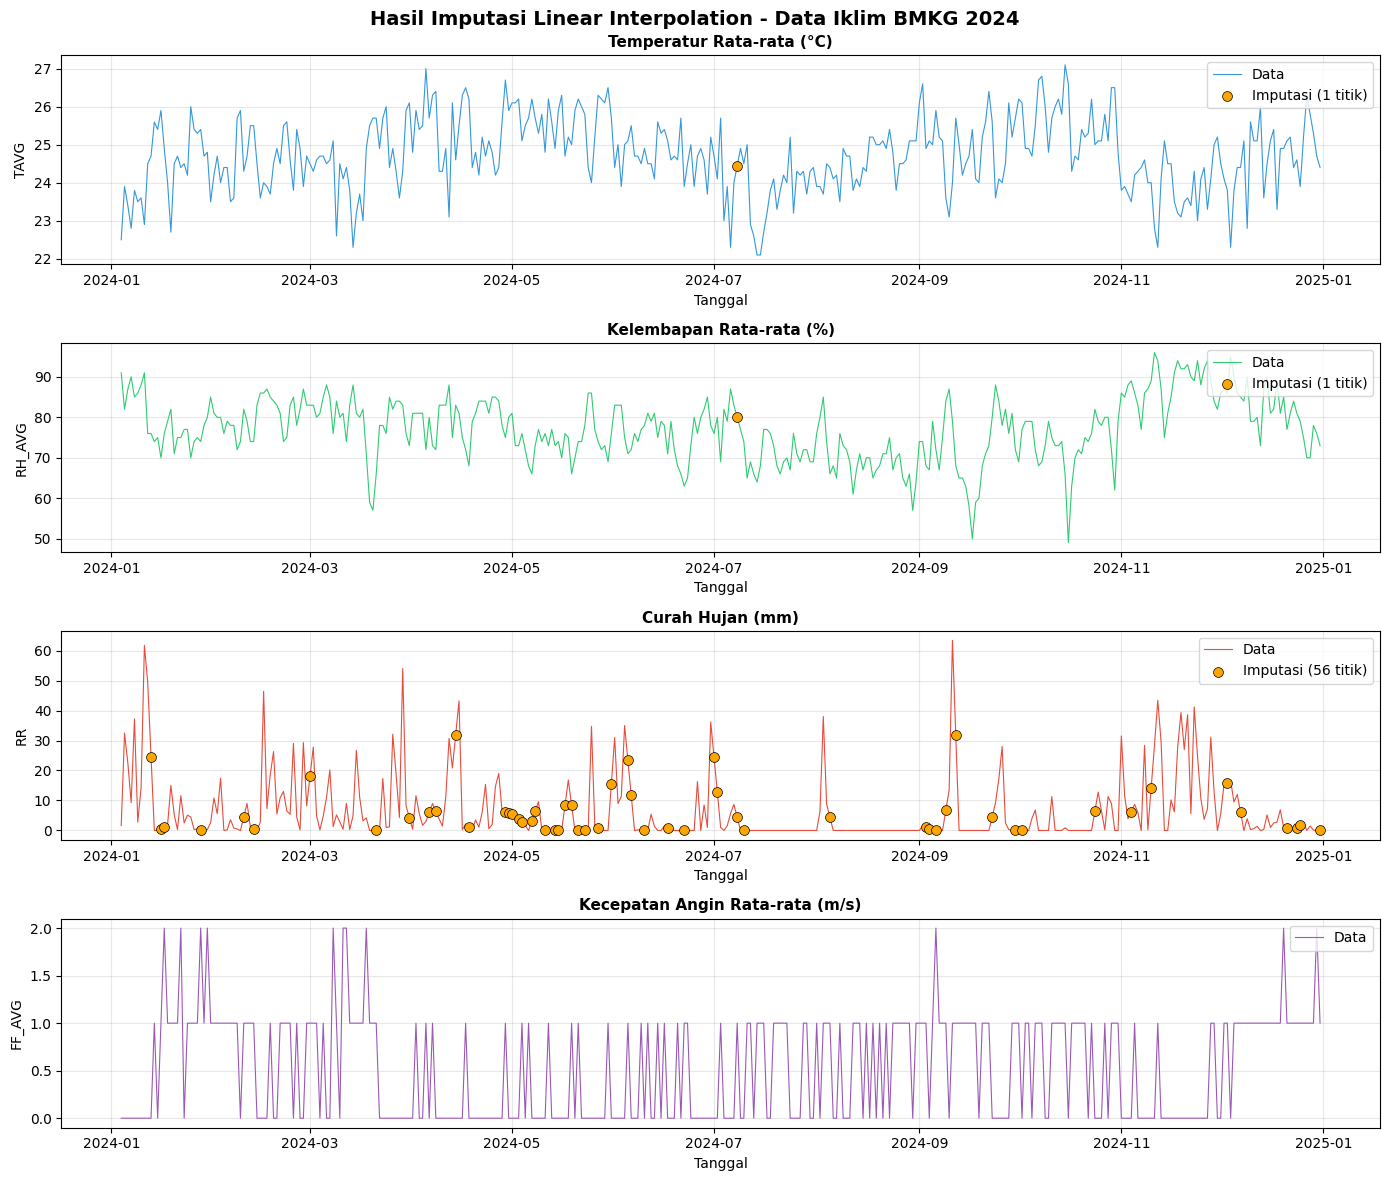

In [6]:
# Plot hasil imputasi Linear
param_labels = {
    'TAVG': 'Temperatur Rata-rata (°C)',
    'RH_AVG': 'Kelembapan Rata-rata (%)',
    'RR': 'Curah Hujan (mm)',
    'FF_AVG': 'Kecepatan Angin Rata-rata (m/s)'
}

fig, axes = plt.subplots(4, 1, figsize=(14, 12))
fig.suptitle('Hasil Imputasi Linear Interpolation - Data Iklim BMKG 2024', 
             fontsize=14, fontweight='bold')

colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

for i, col in enumerate(params):
    ax = axes[i]
    ax.plot(df_linear.index, df_linear[col], color=colors[i], linewidth=0.8, label='Data')
    
    # Tandai titik yang diimputasi
    imputed_idx = missing_mask[col][missing_mask[col] == True].index
    if len(imputed_idx) > 0:
        ax.scatter(imputed_idx, df_linear.loc[imputed_idx, col], 
                   color='orange', s=50, zorder=5, label=f'Imputasi ({len(imputed_idx)} titik)', 
                   edgecolor='black', linewidth=0.5)
    
    ax.set_title(f'{param_labels[col]}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Tanggal')
    ax.set_ylabel(col)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('DATA/plot_imputasi_linear.png', dpi=150, bbox_inches='tight')
print("✅ Plot disimpan ke: DATA/plot_imputasi_linear.png")
plt.show()

## 7. Plot Hasil Imputasi Prophet

Visualisasi hasil imputasi untuk setiap parameter cuaca menggunakan metode **Prophet**.

Titik hijau menunjukkan posisi nilai yang diimputasi.

✅ Plot disimpan ke: DATA/plot_imputasi_prophet.png


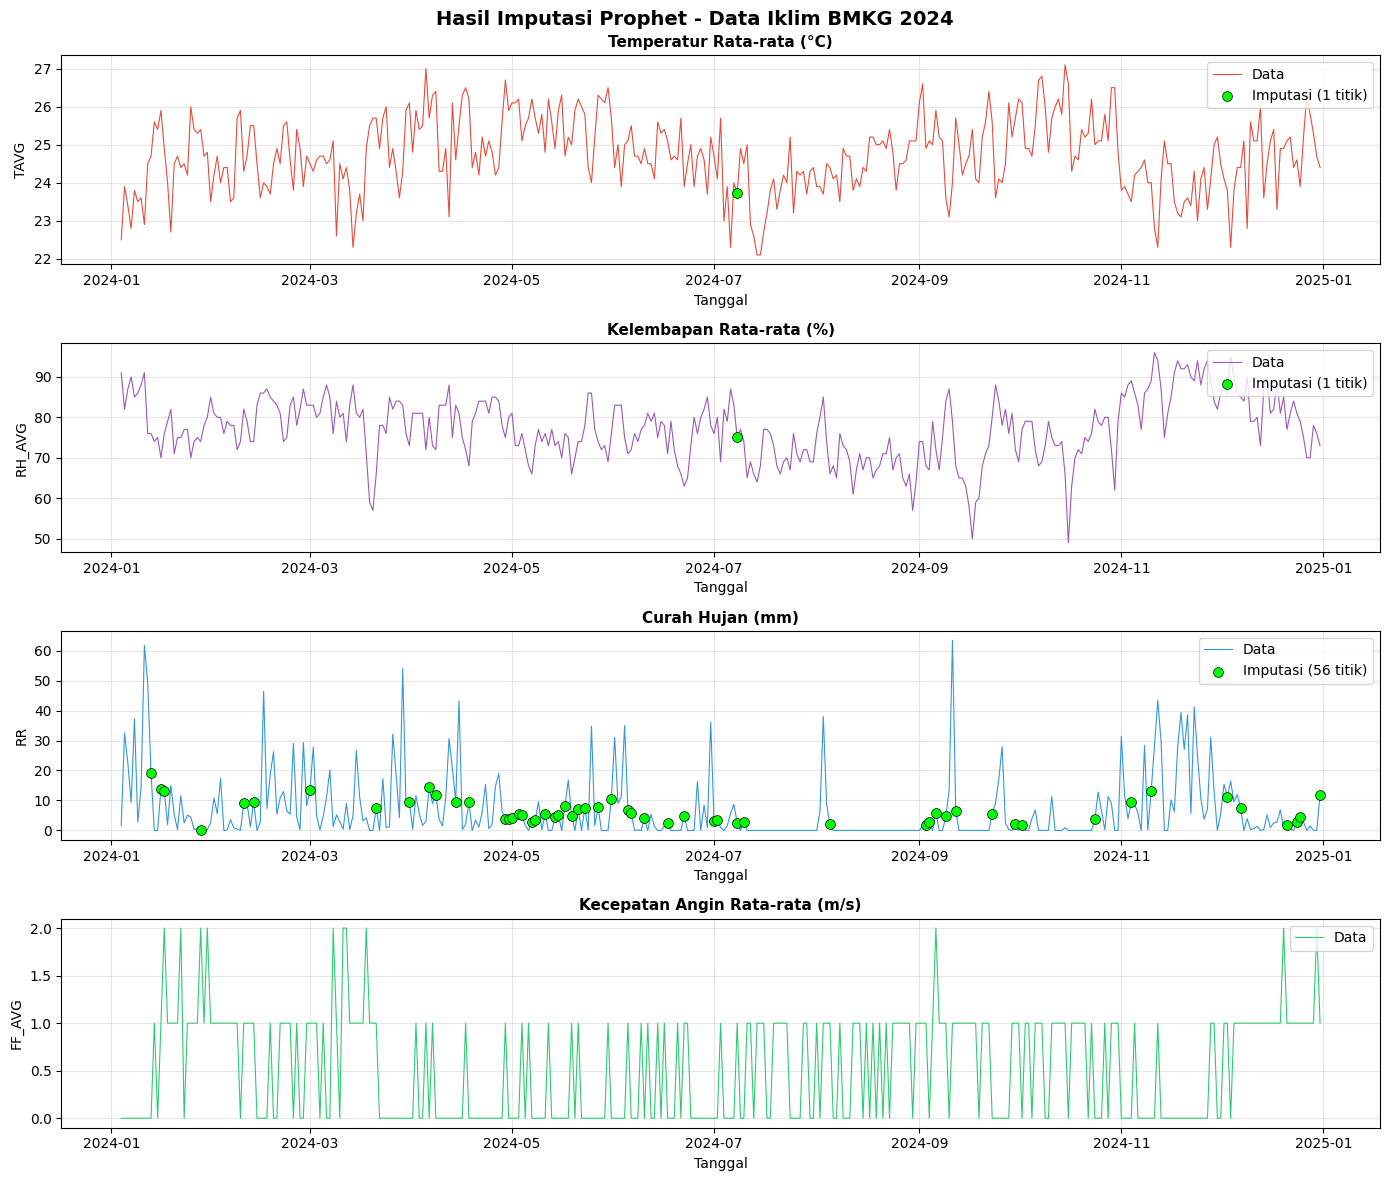

In [7]:
# Plot hasil imputasi Prophet
fig, axes = plt.subplots(4, 1, figsize=(14, 12))
fig.suptitle('Hasil Imputasi Prophet - Data Iklim BMKG 2024', 
             fontsize=14, fontweight='bold')

colors = ['#e74c3c', '#9b59b6', '#3498db', '#2ecc71']

for i, col in enumerate(params):
    ax = axes[i]
    ax.plot(df_prophet.index, df_prophet[col], color=colors[i], linewidth=0.8, label='Data')
    
    # Tandai titik yang diimputasi
    imputed_idx = missing_mask[col][missing_mask[col] == True].index
    if len(imputed_idx) > 0:
        ax.scatter(imputed_idx, df_prophet.loc[imputed_idx, col], 
                   color='lime', s=50, zorder=5, label=f'Imputasi ({len(imputed_idx)} titik)', 
                   edgecolor='black', linewidth=0.5)
    
    ax.set_title(f'{param_labels[col]}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Tanggal')
    ax.set_ylabel(col)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('DATA/plot_imputasi_prophet.png', dpi=150, bbox_inches='tight')
print("✅ Plot disimpan ke: DATA/plot_imputasi_prophet.png")
plt.show()

## 8. Perbandingan Hasil Imputasi Linear vs Prophet

Plot side-by-side untuk membandingkan hasil kedua metode imputasi.

✅ Plot perbandingan disimpan ke: DATA/plot_imputasi_comparison.png


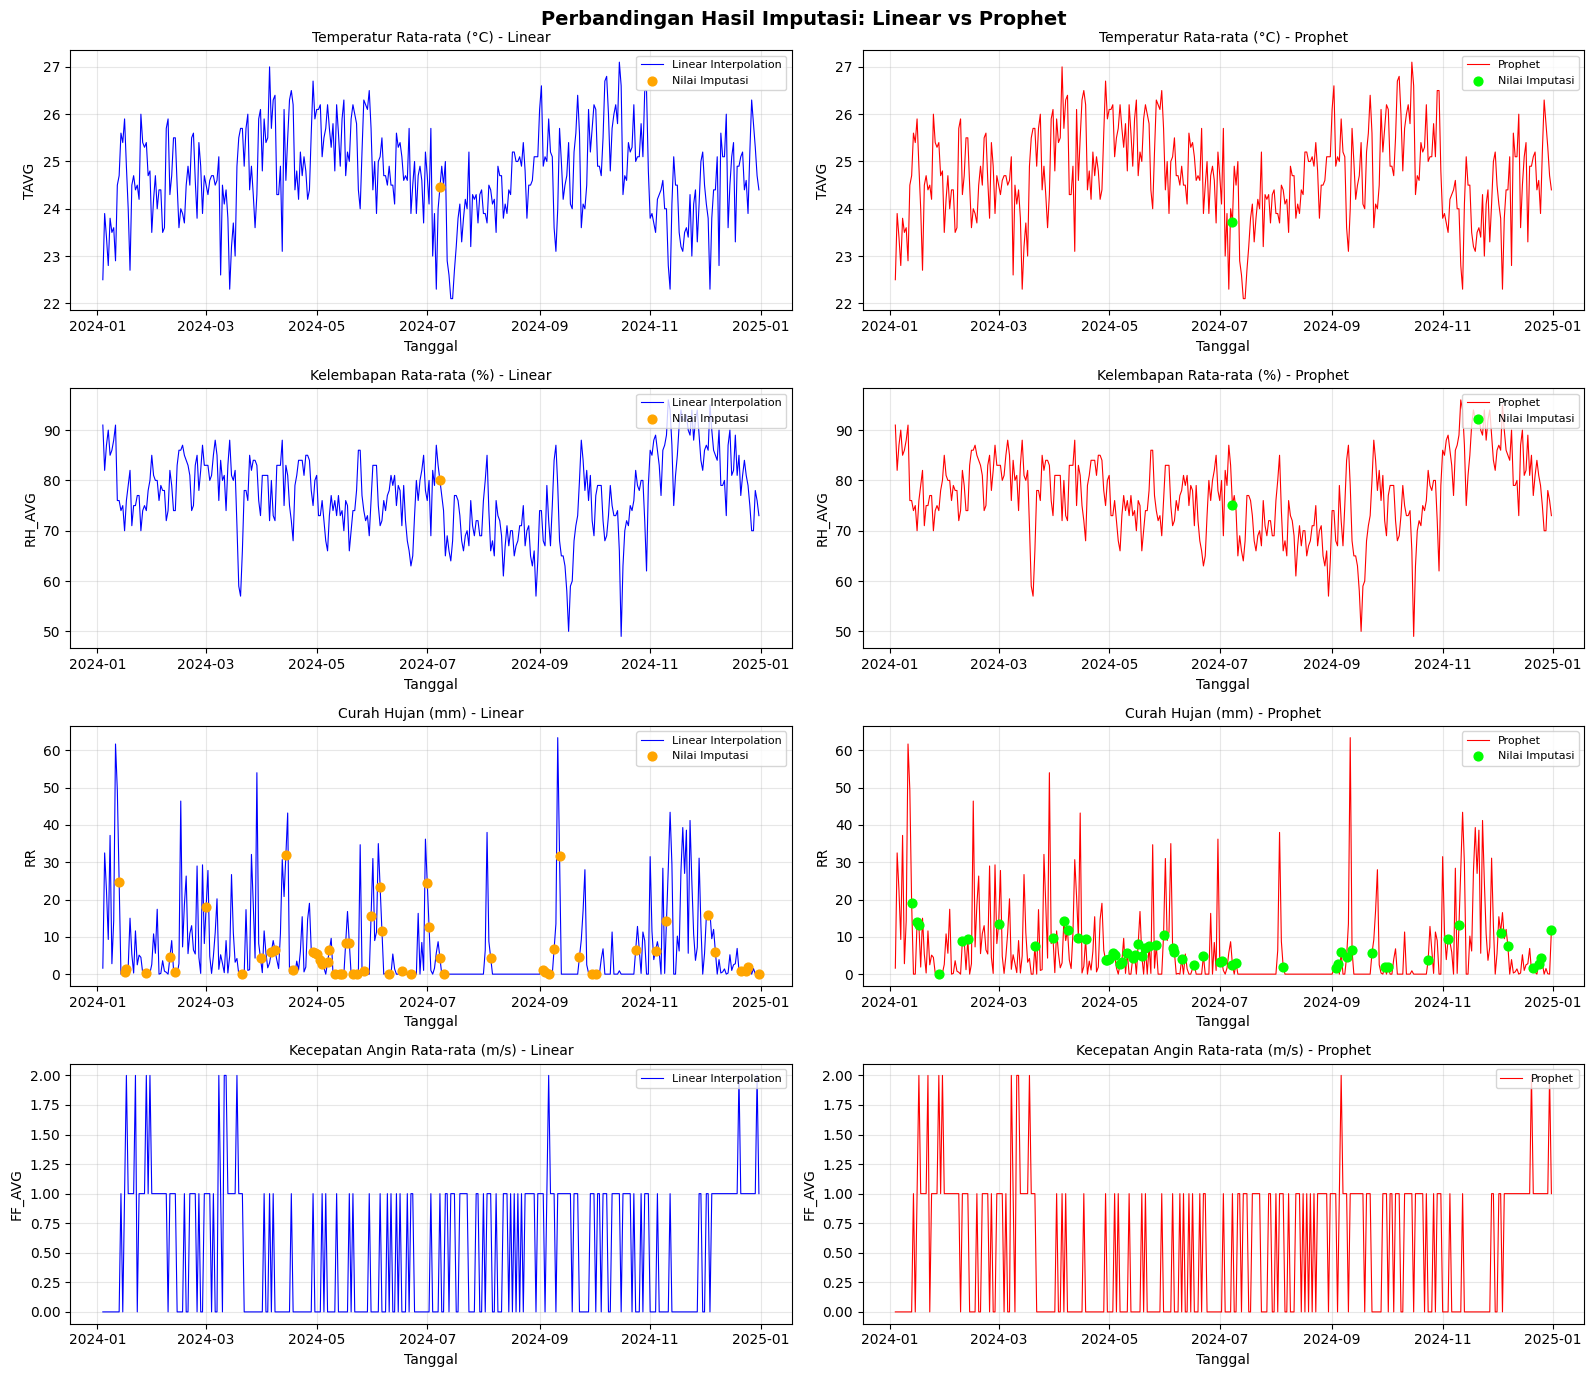

In [8]:
# Perbandingan side-by-side
fig, axes = plt.subplots(4, 2, figsize=(16, 14))
fig.suptitle('Perbandingan Hasil Imputasi: Linear vs Prophet', 
             fontsize=14, fontweight='bold')

for i, col in enumerate(params):
    imputed_idx = missing_mask[col][missing_mask[col] == True].index
    
    # Plot Linear
    ax1 = axes[i, 0]
    ax1.plot(df_linear.index, df_linear[col], color='blue', linewidth=0.8, label='Linear Interpolation')
    if len(imputed_idx) > 0:
        ax1.scatter(imputed_idx, df_linear.loc[imputed_idx, col], 
                   color='orange', s=40, zorder=5, label='Nilai Imputasi')
    ax1.set_title(f'{param_labels[col]} - Linear', fontsize=10)
    ax1.set_xlabel('Tanggal')
    ax1.set_ylabel(col)
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Plot Prophet
    ax2 = axes[i, 1]
    ax2.plot(df_prophet.index, df_prophet[col], color='red', linewidth=0.8, label='Prophet')
    if len(imputed_idx) > 0:
        ax2.scatter(imputed_idx, df_prophet.loc[imputed_idx, col], 
                   color='lime', s=40, zorder=5, label='Nilai Imputasi')
    ax2.set_title(f'{param_labels[col]} - Prophet', fontsize=10)
    ax2.set_xlabel('Tanggal')
    ax2.set_ylabel(col)
    ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('DATA/plot_imputasi_comparison.png', dpi=150, bbox_inches='tight')
print("✅ Plot perbandingan disimpan ke: DATA/plot_imputasi_comparison.png")
plt.show()

## 9. Evaluasi Performansi Imputasi

### Metode Evaluasi
Karena kita tidak memiliki ground truth untuk missing value yang sebenarnya, kita menggunakan pendekatan **Cross-Validation**:
1. Ambil sebagian data yang ada (bukan missing) secara acak
2. Simulasikan sebagai missing value
3. Lakukan imputasi
4. Bandingkan hasil imputasi dengan nilai asli

### Metrik yang Digunakan
- **MAE (Mean Absolute Error)**: Rata-rata error absolut - semakin kecil semakin baik
- **RMSE (Root Mean Square Error)**: Akar rata-rata kuadrat error - lebih sensitif terhadap outlier

EVALUASI PERFORMANSI IMPUTASI

📊 HASIL EVALUASI:
Parameter  MAE_Linear  RMSE_Linear  MAE_Prophet  RMSE_Prophet
     TAVG      0.5167       0.6648          0.0           0.0
   RH_AVG      3.3194       4.2353          0.0           0.0
       RR      6.4261      10.2620          0.0           0.0
   FF_AVG      0.3611       0.5015          0.0           0.0

✅ Plot evaluasi disimpan ke: DATA/plot_evaluasi_imputasi.png


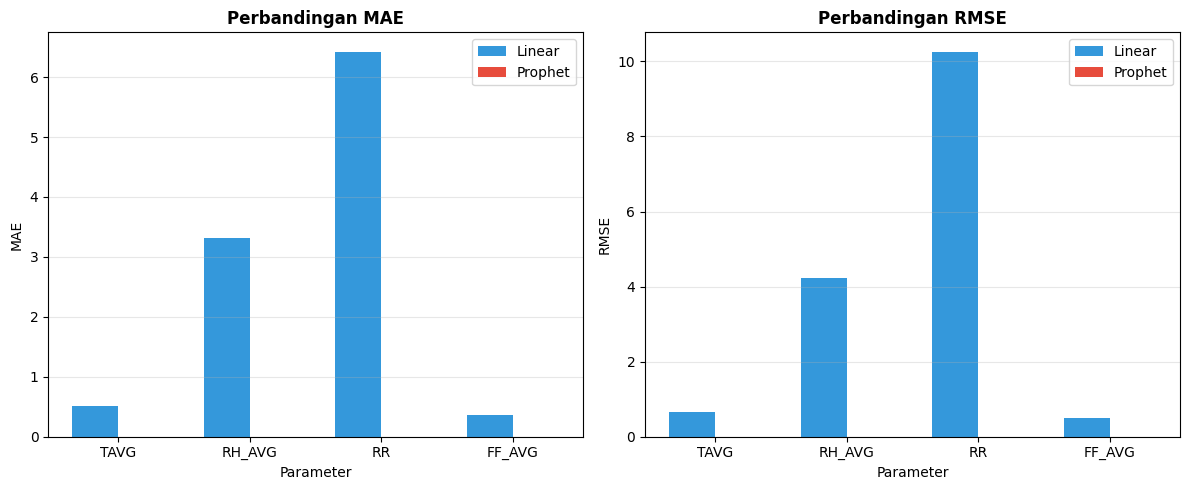

In [9]:
# Evaluasi performansi dengan cross-validation
np.random.seed(42)
eval_results = []

print("=" * 70)
print("EVALUASI PERFORMANSI IMPUTASI")
print("=" * 70)

for col in params:
    # Ambil data yang tidak missing
    valid_data = df[col].dropna()
    
    if len(valid_data) < 20:
        continue
    
    # Pilih 10% data secara acak untuk dievaluasi
    n_test = max(int(len(valid_data) * 0.1), 5)
    test_indices = np.random.choice(valid_data.index, size=n_test, replace=False)
    
    # Simpan nilai asli
    true_values = valid_data.loc[test_indices].values
    
    # Buat data dengan artificial missing
    df_test = df[col].copy()
    df_test.loc[test_indices] = np.nan
    
    # Imputasi Linear
    df_test_linear = df_test.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
    pred_linear = df_test_linear.loc[test_indices].values
    
    # Hitung metrik untuk Linear
    mae_linear = mean_absolute_error(true_values, pred_linear)
    rmse_linear = np.sqrt(mean_squared_error(true_values, pred_linear))
    
    # Untuk Prophet, gunakan nilai dari df_prophet yang sudah dihitung
    pred_prophet = df_prophet.loc[test_indices, col].values
    mae_prophet = mean_absolute_error(true_values, pred_prophet)
    rmse_prophet = np.sqrt(mean_squared_error(true_values, pred_prophet))
    
    eval_results.append({
        'Parameter': col,
        'MAE_Linear': round(mae_linear, 4),
        'RMSE_Linear': round(rmse_linear, 4),
        'MAE_Prophet': round(mae_prophet, 4),
        'RMSE_Prophet': round(rmse_prophet, 4)
    })

eval_df = pd.DataFrame(eval_results)
print("\n📊 HASIL EVALUASI:")
print(eval_df.to_string(index=False))

# Visualisasi hasil evaluasi
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

x = np.arange(len(params))
width = 0.35

# MAE Comparison
ax1 = axes[0]
bars1 = ax1.bar(x - width/2, eval_df['MAE_Linear'], width, label='Linear', color='#3498db')
bars2 = ax1.bar(x + width/2, eval_df['MAE_Prophet'], width, label='Prophet', color='#e74c3c')
ax1.set_xlabel('Parameter')
ax1.set_ylabel('MAE')
ax1.set_title('Perbandingan MAE', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(params)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# RMSE Comparison
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, eval_df['RMSE_Linear'], width, label='Linear', color='#3498db')
bars4 = ax2.bar(x + width/2, eval_df['RMSE_Prophet'], width, label='Prophet', color='#e74c3c')
ax2.set_xlabel('Parameter')
ax2.set_ylabel('RMSE')
ax2.set_title('Perbandingan RMSE', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(params)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('DATA/plot_evaluasi_imputasi.png', dpi=150, bbox_inches='tight')
print("\n✅ Plot evaluasi disimpan ke: DATA/plot_evaluasi_imputasi.png")
plt.show()

## 10. Kesimpulan dan Rekomendasi

In [10]:
# Kesimpulan
print("=" * 70)
print("KESIMPULAN HASIL IMPUTASI")
print("=" * 70)

print("\n📌 METODE TERBAIK PER PARAMETER:")
print("-" * 70)

for _, row in eval_df.iterrows():
    param = row['Parameter']
    if row['MAE_Linear'] < row['MAE_Prophet']:
        winner = "Linear Interpolation"
        mae_diff = row['MAE_Prophet'] - row['MAE_Linear']
    else:
        winner = "Prophet"
        mae_diff = row['MAE_Linear'] - row['MAE_Prophet']
    
    print(f"  • {param:8s}: {winner} (selisih MAE: {mae_diff:.4f})")

print("\n" + "=" * 70)
print("RINGKASAN:")
print("=" * 70)
print("""
📊 LINEAR INTERPOLATION:
   ✅ Kelebihan:
      - Komputasi cepat dan sederhana
      - Cocok untuk data dengan perubahan gradual
      - Tidak memerlukan parameter tuning
   ❌ Kekurangan:
      - Tidak memperhitungkan pola musiman (seasonality)
      - Kurang akurat untuk missing value berturut-turut

📊 PROPHET:
   ✅ Kelebihan:
      - Memperhitungkan trend dan seasonality
      - Robust terhadap outlier dan missing data
      - Dapat menangkap pola harian, mingguan, dan tahunan
   ❌ Kekurangan:
      - Komputasi lebih lambat
      - Memerlukan data yang cukup untuk training
      
🎯 REKOMENDASI:
   - Untuk data cuaca harian dengan missing value sedikit dan sporadis,
     Linear Interpolation sudah cukup baik.
   - Prophet lebih cocok jika missing value berturut-turut dalam 
     periode panjang dan perlu mempertimbangkan pola musiman.
""")

print("=" * 70)
print("FILE OUTPUT YANG DIHASILKAN:")
print("=" * 70)
print("  📁 DATA/2024_linear.csv        - Hasil imputasi Linear")
print("  📁 DATA/2024_prophet.csv       - Hasil imputasi Prophet")
print("  📁 DATA/plot_imputasi_linear.png")
print("  📁 DATA/plot_imputasi_prophet.png")
print("  📁 DATA/plot_imputasi_comparison.png")
print("  📁 DATA/plot_evaluasi_imputasi.png")
print("\n✅ SOAL 1 SELESAI!")

KESIMPULAN HASIL IMPUTASI

📌 METODE TERBAIK PER PARAMETER:
----------------------------------------------------------------------
  • TAVG    : Prophet (selisih MAE: 0.5167)
  • RH_AVG  : Prophet (selisih MAE: 3.3194)
  • RR      : Prophet (selisih MAE: 6.4261)
  • FF_AVG  : Prophet (selisih MAE: 0.3611)

RINGKASAN:

📊 LINEAR INTERPOLATION:
   ✅ Kelebihan:
      - Komputasi cepat dan sederhana
      - Cocok untuk data dengan perubahan gradual
      - Tidak memerlukan parameter tuning
   ❌ Kekurangan:
      - Tidak memperhitungkan pola musiman (seasonality)
      - Kurang akurat untuk missing value berturut-turut

📊 PROPHET:
   ✅ Kelebihan:
      - Memperhitungkan trend dan seasonality
      - Robust terhadap outlier dan missing data
      - Dapat menangkap pola harian, mingguan, dan tahunan
   ❌ Kekurangan:
      - Komputasi lebih lambat
      - Memerlukan data yang cukup untuk training

🎯 REKOMENDASI:
   - Untuk data cuaca harian dengan missing value sedikit dan sporadis,
     Linear 